In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# import lib 
import os
from tqdm.notebook import tqdm
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
# Checking device: cuda or cpu
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

In [3]:
data_dir_train = '../input/fruits/fruits-360_dataset/fruits-360/Training'
data_dir_test = '../input/fruits/fruits-360_dataset/fruits-360/Test'

In [4]:
size_pictures = 100
data_transforms = transforms.Compose([transforms.Resize((size_pictures, size_pictures)),
                                 transforms.ToTensor()])

In [5]:
dataset = ImageFolder(root=data_dir_train,transform=data_transforms)
data_test = ImageFolder(root=data_dir_test,transform=data_transforms)
print(len(dataset), len(data_test))

67692 22688


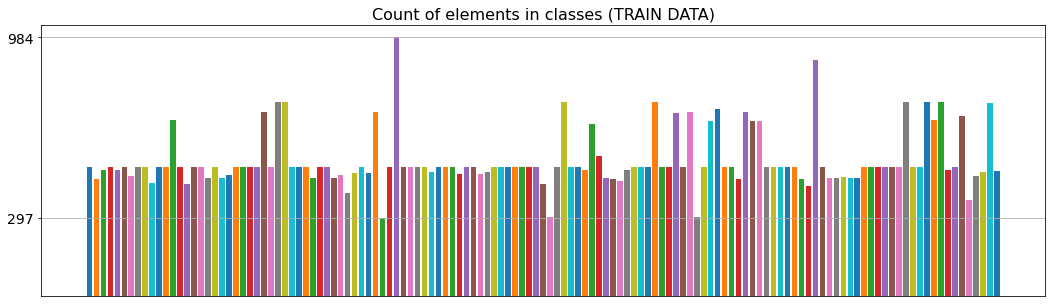

In [6]:
#Show data balance in train
labels_count = {}
for image in dataset.imgs:
    label = image[1]
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(18, 5));
for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);     
plt.title('Count of elements in classes (TRAIN DATA)', fontsize=16)
plt.xticks([]);
plt.grid()
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14);



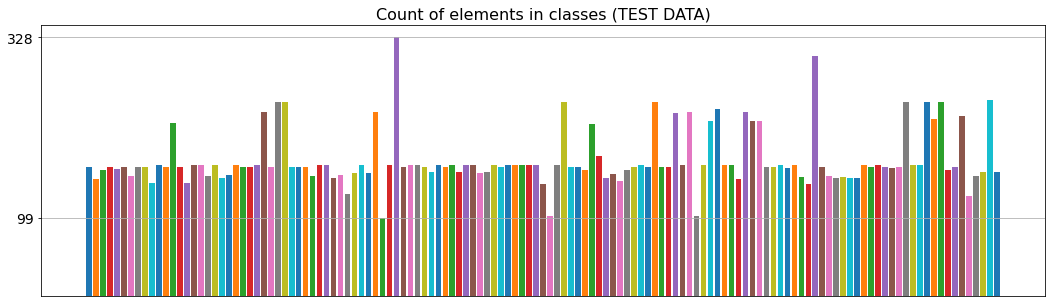

In [7]:
#Show data balance in test
labels_count = {}
for image in data_test.imgs:
    label = image[1]
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(18, 5));
for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);     
plt.title('Count of elements in classes (TEST DATA)', fontsize=16)
plt.xticks([]);
plt.grid()
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14);





In [8]:
def show_random_image():
    index = np.random.randint(0,len(dataset))
    return dataset[index]

In [9]:
img, label = show_random_image()

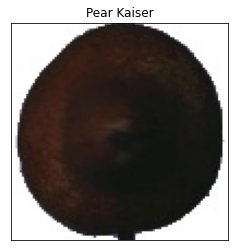

In [11]:
img, label = show_random_image()
plt.title(dataset.classes[label])
plt.imshow(img.permute(1, 2, 0));
plt.xticks([]);
plt.yticks([]);

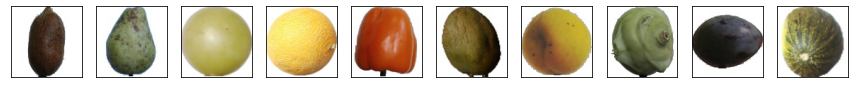

In [13]:
fig = plt.figure(figsize=(15,15));
for i in range(1,11):
    plt.subplot(1,10, i,)
#     plt.title(dataset.classes[label])
    img, label = show_random_image()
    plt.imshow(img.permute(1, 2, 0));
    plt.xticks([]);
    plt.yticks([]);

In [14]:
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(54153, 13539)

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=7, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=7, out_channels=10, kernel_size=5, padding=2)
        self.act2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        #6250
        self.fc1 = nn.Linear(6250,  1048)
        self.act3 = nn.ReLU()
        
        self.fc2 = nn.Linear(1048, 262)
        self.act4 = nn.Sigmoid()
        
        self.fc3 = nn.Linear(262, 131)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)  
        
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        
        x = self.fc2(x)
        x = self.act4(x)
        
        x = self.fc3(x)
        return x

In [16]:
model = NeuralNetwork()
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr = 10 **(-3))
epoch = 10
batch_size = 256

In [18]:
acc = []
def training(model, batch_size, epochs, loss, optimizer):
    for epoch in range(1, epochs + 1):
        model.train()
        dataloader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
        for (X_batch,y_batch) in tqdm(dataloader): 
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model.forward(X_batch)
            
            loss_value = loss(preds, y_batch.long())
            loss_value.backward()
            
            optimizer.step()

        dataloader_test = DataLoader(dataset=val_ds, batch_size=256)
        model.eval()
        with torch.no_grad():
            summa = 0
            for (X_batch,y_batch) in tqdm(dataloader_test):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)
                preds = torch.max(F.softmax(preds, dim=1), dim=1)
                correct= torch.eq(preds[1], y_batch)
                summa += torch.sum(correct).item()

            acc.append(summa / len(val_ds))
            print(f'epoch: {epoch}, acc:{acc[-1]:.2%}')

In [19]:
%%time
training(model, batch_size, epoch, loss, optimizer)



  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 1, acc:75.65%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 2, acc:92.74%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 3, acc:98.81%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 4, acc:99.68%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 5, acc:99.90%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 6, acc:99.87%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 7, acc:99.93%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 8, acc:99.98%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 9, acc:99.75%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 10, acc:99.93%
CPU times: user 7min 43s, sys: 44.6 s, total: 8min 28s
Wall time: 16min 12s


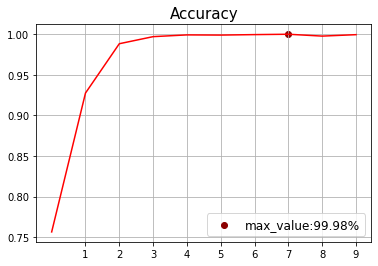

In [20]:
acc_max = max(acc)
y_acc_max = acc.index(max(acc))
plt.title('Accuracy', fontsize = 15 );
plt.xticks(np.arange(1, epoch));
plt.scatter( y_acc_max, acc_max, color='darkred', label = f'max_value:{acc_max:.2%}');
plt.plot(acc, color='red', );
plt.grid()
plt.legend(fontsize = 12);

In [21]:
dataloader_test = DataLoader(dataset=data_test, batch_size=256)
summa = 0
y_true = []
y_pred = []
for (X_batch,y_batch) in tqdm(dataloader_test):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = model.forward(X_batch)
    val_predict_class = preds.argmax(dim=-1)

    y_pred.extend([predict_class.item() for predict_class in val_predict_class])
    y_true.extend([val_label.item() for val_label in y_batch])

  0%|          | 0/89 [00:00<?, ?it/s]

In [22]:
print(f'acc:{accuracy_score(y_true, y_pred):.2%}')

acc:93.79%


In [23]:
cl_report = classification_report(y_true, y_pred,output_dict=True,
                               target_names=dataset.classes)

In [24]:
report_df = pd.DataFrame(cl_report).T.sort_values(by=['precision', 'recall', 'f1-score'], ascending=False)
report_df.drop(['support'], axis=1, inplace=True)
report_df

,precision,recall,f1-score
Apple Red Yellow 2,1.000000,1.000000,1.000000
Cantaloupe 1,1.000000,1.000000,1.000000
Cherry 2,1.000000,1.000000,1.000000
Cherry Wax Black,1.000000,1.000000,1.000000
Cherry Wax Red,1.000000,1.000000,1.000000
...,...,...,...
Apple Pink Lady,0.771574,1.000000,0.871060
Potato Red,0.765823,0.806667,0.785714
Nectarine,0.764368,0.810976,0.786982
Banana Lady Finger,0.603175,1.000000,0.752475


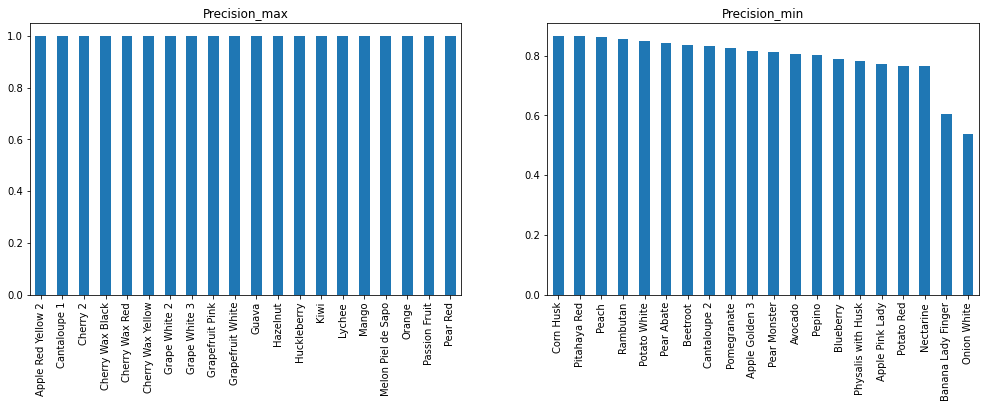

In [25]:
max_values = report_df.head(20)
min_values = report_df.tail(20)

plt.figure(figsize=(17, 5))


plt.subplot(1, 2, 1);
plt.title('Precision_max');
max_values['precision'].plot.bar();

plt.subplot(1, 2, 2);
plt.title('Precision_min');
min_values['precision'].plot.bar();